# Optical Flow exploration notebook

In [1]:
import os
# both for tensorflow and pycuda
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

sys.path.insert(0, '../')

import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [4]:
from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [5]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

warped_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

## Timings

first, we check the git branches in the ofco source code,

In [1]:
!cd ../src/ofco && git branch

  fft-tf
* master


### NUMPY with process-level parallelism

<pre>
results (20 frames):                       <mono>Elapsed 265.1s | 13.26s per frame</mono>
with thread-level parallelism (20 frames): <mono>Elapsed 227.7s | 11.39s per frame</mono>
</pre>

This is the old -> slower approach.

In [5]:
# first we make sure we are in the main branch
! cd ../src/ofco && git checkout master

import time
import logging
from ofco import motion_compensate
from ofco.utils import default_parameters

# by defualt Jupyter does not show info logs, so we activate them
logging.getLogger().setLevel(logging.INFO)

# number of frames to register
N = 20

key = range(N)

stack1 = tiff.imread(orig_examples[1], key=key)

param = default_parameters()
frames = [i for i in key]

t1 = time.perf_counter()
stack1_warped, _ = motion_compensate(stack1, None, frames, param,
                                     verbose=True, parallel=True)
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.4g}s | {(t2-t1)/N:.4g}s per frame')

Already on 'master'
Your branch is up to date with 'origin/master'.
Time it took to normalize images 0.029538932256400585
Time it took to compute motion field w 264.8360588941723
Time it took to warp images 0.28110021352767944
Elapsed 265.1s | 13.26s per frame


In [6]:
make_video('ofco-master', frame_gen(stack1_warped))
Video('ofco-master.mov')

calculated std


20it [00:00, 236.49it/s]

converting video..


Done (0.20s)


### TENSORFLOW with thread-level parallelism

`Elapsed 169.9s | 8.494s per frame`

Here we replaced fft2 and ifft2 with the tensorflow's functions

In [5]:
# first we make sure we are in the feature branch
! cd ../src/ofco && git checkout fft-tf

import time
from ofco import motion_compensate
from ofco.utils import default_parameters

N = 20

key = range(N)

stack1 = tiff.imread(orig_examples[1], key=key)

param = default_parameters()
frames = [i for i in key]

t1 = time.perf_counter()
stack1_warped, _ = motion_compensate(stack1, None, frames, param,
                                     verbose=True, parallel=True)
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.4g}s | {(t2-t1)/N:.4g}s per frame')

[2021-11-16 18:13:29,533] I T139949250716032 main.py:107: Time it took to normalize images 0.03080111276358366
INFO:ofco:Time it took to normalize images 0.03080111276358366
[2021-11-16 18:13:29,534] I T139949250716032 utils.py:362: Num Physical GPUs Available: 1
INFO:ofco:Num Physical GPUs Available: 1
[2021-11-16 18:13:29,535] I T139949250716032 utils.py:363: Num Logical  GPUs Available: 1
INFO:ofco:Num Logical  GPUs Available: 1
[2021-11-16 18:13:29,535] I T139949250716032 utils.py:364: Num TPUs Available: 0
INFO:ofco:Num TPUs Available: 0
[2021-11-16 18:13:29,536] I T139949250716032 utils.py:394: using default strategy.
INFO:ofco:using default strategy.
[2021-11-16 18:13:30,981] I T139940461520640 optflow.py:169: Converged scale 10 and warp 0 in it=54 iterations
INFO:ofco:Converged scale 10 and warp 0 in it=54 iterations
[2021-11-16 18:13:31,549] I T139940478306048 optflow.py:169: Converged scale 10 and warp 0 in it=97 iterations
INFO:ofco:Converged scale 10 and warp 0 in it=97 ite

Time it took to compute motion field w 167.70025293156505
Time it took to warp images 0.2894687745720148
Elapsed 168s | 8.402s per frame


In [6]:
make_video('ofco-fft-tf', frame_gen(stack1_warped))
Video('ofco-fft-tf.mov')

calculated std


20it [00:00, 234.30it/s]

converting video..


Done (0.26s)


### PYCUDA & SCIKIT-CUDA with thread-level parallelism

`Elapsed 498.7s | 24.94s per frame`

In [1]:
# first we make sure we are in the feature branch
! cd ../src/ofco && git checkout fft-pycuda-skcuda

import time
from ofco import motion_compensate
from ofco.utils import default_parameters

N = 8

key = range(N)

stack1 = tiff.imread(orig_examples[1], key=key)

param = default_parameters()
frames = [i for i in key]

t1 = time.perf_counter()
stack1_warped, _ = motion_compensate(stack1, None, frames, param,
                                     verbose=True, parallel=True)
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.4g}s | {(t2-t1)/N:.4g}s per frame')
np.save('ofco-fft-pycuda-skcuda.npy', stack1_warped)

Switched to branch 'fft-pycuda-skcuda'
Your branch is up to date with 'origin/fft-pycuda-skcuda'.


ModuleNotFoundError: No module named 'pycuda'

In [ ]:
test = np.load('ofco-fft-pycuda-skcuda.npy')
assert np.allclose(stack1_warped, test)
make_video('ofco-fft-pycuda-skcuda', frame_gen(stack1_warped))
Video('ofco-fft-pycuda-skcuda.mov')

### PYFFTW with thread-level parallelism

` `

In [4]:
import numpy as np
import pyfftw
import pyfftw.interfaces.numpy_fft as fftw
W, H = 20, 40
muwalpha0 = pyfftw.empty_aligned((W, H), dtype='float32')
w = pyfftw.ones_aligned((W, H, 2), dtype='float32')
mu = 2.0
alpha = 1.0
muwalpha0[:] = mu * w[..., 0] + alpha
a = fftw.ifft2(fftw.fft2(muwalpha0))
np.allclose(a, muwalpha0)

b = np.fft.ifft2(np.fft.fft2(muwalpha0))

np.allclose(b, muwalpha0)


True

In [ ]:
# first we make sure we are in the feature branch
! cd ../src/ofco && git checkout fft-pyFFTW

import time
from ofco import motion_compensate
from ofco.utils import default_parameters

N = 8

key = range(N)

stack1 = tiff.imread(orig_examples[1], key=key)

param = default_parameters()
frames = [i for i in key]

t1 = time.perf_counter()
stack1_warped, _ = motion_compensate(stack1, None, frames, param,
                                     verbose=True, parallel=True)
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.4g}s | {(t2-t1)/N:.4g}s per frame')
np.save('ofco-fft-pyfftw.npy', stack1_warped)

M	ofco/main.py
M	ofco/optflow.py
M	ofco/utils.py
Already on 'fft-pyFFTW'
Time it took to normalize images 0.020302771998103708


[2021-11-25 22:15:44,461] I T140124364986112 optflow.py:167: Converged scale 10 and warp 0 in it=41 iterations
[2021-11-25 22:15:44,531] I T140120506210048 optflow.py:167: Converged scale 10 and warp 0 in it=54 iterations
[2021-11-25 22:15:44,672] I T140120497817344 optflow.py:167: Converged scale 10 and warp 0 in it=70 iterations
[2021-11-25 22:15:44,869] I T140124641814272 optflow.py:167: Converged scale 10 and warp 0 in it=120 iterations
[2021-11-25 22:15:44,961] I T140120514602752 optflow.py:167: Converged scale 10 and warp 0 in it=108 iterations
[2021-11-25 22:15:45,013] I T140124222375680 optflow.py:167: Converged scale 10 and warp 0 in it=116 iterations


In [ ]:
test = np.load('ofco-fft-pyfftw.npy')
assert np.allclose(stack1_warped, test)
make_video('ofco-fft-pyfftw', frame_gen(stack1_warped))
Video('ofco-fft-pyfftw.mov')

## INTERPOLATION TESTS

In [43]:
np.linspace(0.1, 0.9, 9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [45]:
test = np.load('ofco-fft-pycuda-skcuda.npy')
f_init = test[0]
f_final = test[-1]
F_init = np.fft.fft2(f_init)
F_final = np.fft.fft2(f_final)

# interpolate 20 frames
N = 20
interpol_frames = []
for alpha in np.linspace(0.0, 1.0, N)[1:-1]:
    F = alpha * F_final + (1 - alpha) * F_init
    f = np.real(np.fft.ifft2(F))
    interpol_frames += [f]

video = np.stack([f_init] + interpol_frames + [f_final])
print(f'{video.shape=}')
make_video('out', frame_gen(video), fps=3)
Video('out.mov')

video.shape=(20, 480, 736)
calculated std


20it [00:00, 310.33it/s]

converting video..


Done (0.17s)


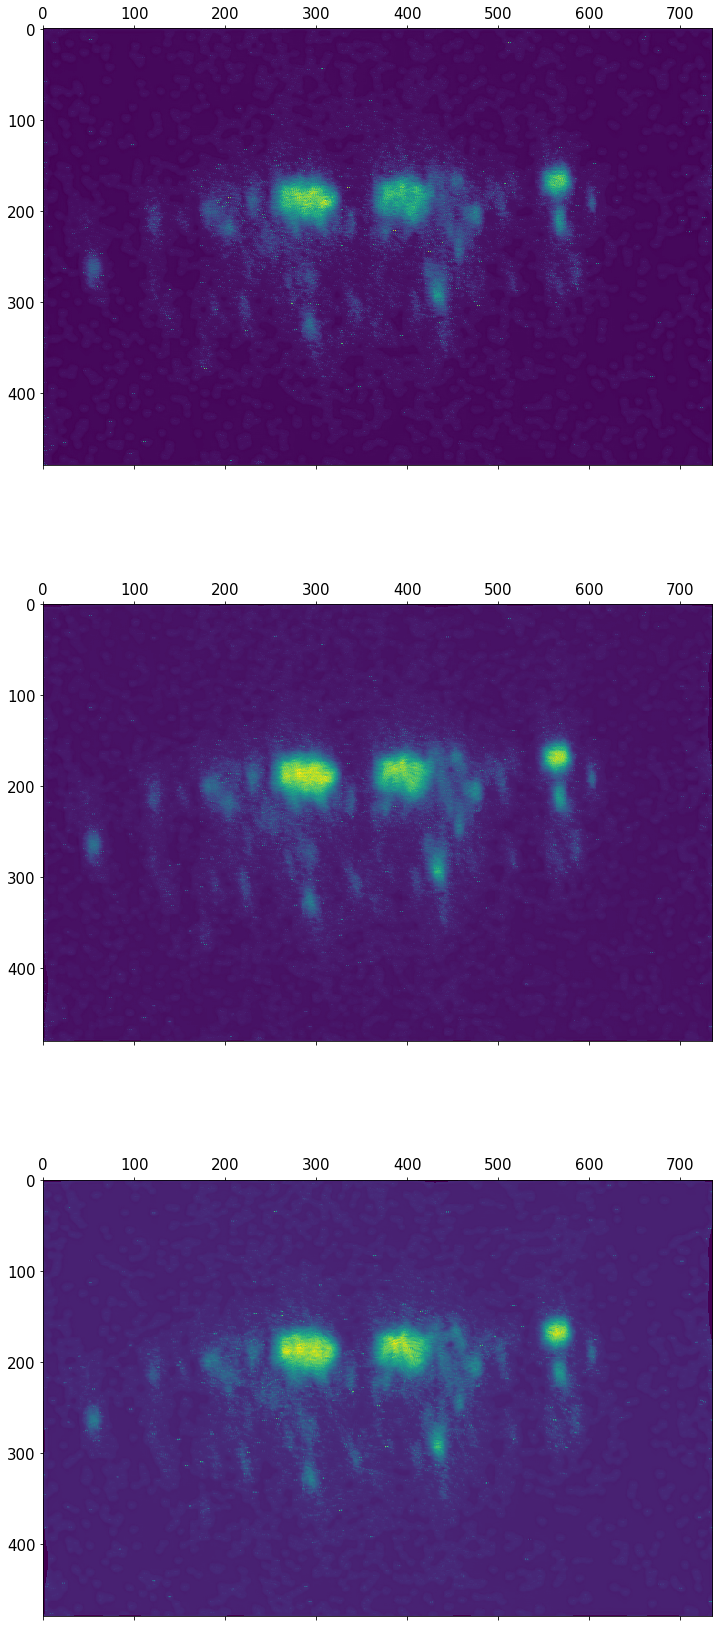

In [41]:
test = np.load('ofco-fft-pycuda-skcuda.npy')
if False:
    res = np.fft.fft2(test[0])
    res_abs = np.abs(res)
    print(f'{res_abs.shape=}')
    min_mod = np.quantile(res_abs, 0.5)
    # qi = (np.abs(res_abs - q)).argmin()
    # qi, qj = qi // res_abs.shape[1], qi % res_abs.shape[1]
    # print(f'{q=} | {qi=}, {qj=}')
    # max_mod = res_abs[qi, qj]
    print(f'{min_mod=}')
    idx = res_abs < min_mod
    res[idx] *= min_mod / res[idx]
    print(f'{np.abs(res).max()}')

    plt.hist(np.abs(res.ravel()), bins=200)
    plt.show()

    res = np.real(np.fft.ifft2(res))
    _,  ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.matshow(res)
    plt.show()

i = 0
f1 = np.fft.fft2(test[i])
f3 = np.fft.fft2(test[i+2])

# interpolation in frequency domain
alpha = 0.5
f2 = alpha * f1 + (1 - alpha) * f3
res = np.real(np.fft.ifft2(f2))

_,  axes = plt.subplots(3, 1, figsize=(12, 3*6))
axes[0].matshow(test[i])
axes[1].matshow(res)
axes[2].matshow(test[i+2])
plt.show()

## Profiling (only profiles main thread!)

Use py-spy instead.

In [14]:
import cProfile
import time
from ofco import motion_compensate
from ofco.utils import default_parameters

N = 5

key = range(N)

# load file to warp
stack1 = tiff.imread(orig_examples[1], key=key)
print(f'{stack1.shape=}')

param = default_parameters()
frames = [i for i in key]

print('Starting profiling..')
t1 = time.perf_counter()
# run ofco and save profiling results to `restats` file
cProfile.run('motion_compensate(stack1, None, frames, param)', 'restats')
t2 = time.perf_counter()
print(f'Finished profiling in {t2-t1:.2f}s')

stack1.shape=(5, 480, 736)
Starting profiling..
Finished profiling in 69.63s


after profiling ofco, we can show which functions took the longest,

In [17]:
import pstats
from pstats import SortKey
p = pstats.Stats('restats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

Sun Nov 14 22:04:22 2021    restats

         6452 function calls (6415 primitive calls) in 69.626 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000   69.626   69.626 {built-in method builtins.exec}
        1    0.000    0.000   69.626   69.626 <string>:1(<module>)
        1    0.005    0.005   69.626   69.626 main.py:81(motion_compensate)
       60    0.000    0.000   69.428    1.157 threading.py:556(wait)
       59    0.000    0.000   69.427    1.177 threading.py:280(wait)
      407   69.427    0.171   69.427    0.171 {method 'acquire' of '_thread.lock' objects}
        1    0.000    0.000   69.415   69.415 pool.py:359(map)
        1    0.000    0.000   69.415   69.415 pool.py:764(get)
        1    0.000    0.000   69.415   69.415 pool.py:761(wait)
        1    0.000    0.000    0.095    0.095 context.py:115(Pool)
        1    0.000    0.000    0.095    0.095 pool.py:183(__init__)
        1    